# 2.2 - GOES16 - Geoprocess

In [1]:
import autoroot
import os
from dotenv import load_dotenv
from pathlib import Path
import earthaccess
import numpy as np
import rioxarray
import xarray as xr
from dataclasses import dataclass
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



xr.set_options(
    keep_attrs=True, 
    display_expand_data=False, 
    display_expand_coords=False, 
    display_expand_data_vars=False, 
    display_expand_indexes=False
)
np.set_printoptions(threshold=10, edgeitems=2)

%load_ext autoreload
%autoreload 2

### Download GOES16

GOES16 is a geostationary satellite so there are very frequent observations.
The data is typically stored as full fields so we need to be smart when selecting the datasets.
For this example, we will only download the data that is available from the MODIS satellite.

In [2]:
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID
from rs_tools._src.utils.io import get_list_filenames
import pandas as pd

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [3]:
# environment variables
save_dir = Path(os.getenv("ITI_DATA_SAVEDIR"))
goes_read_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/raw")
goes_save_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/clean")
goes_read_dir.mkdir(parents=True, exist_ok=True)
goes_save_dir.mkdir(parents=True, exist_ok=True)
goes_read_dir

PosixPath('/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/raw')

We will subset each of them to extract the timestamps when they were retrieved.

In [4]:
# list of all .hdf files in the directory
all_goes_files = get_list_filenames(goes_read_dir, ".nc")

len(all_goes_files)

144

In [5]:
from rs_tools.goes import preprocess_goes16_radiance_band, clean_coords_goes16
from rs_tools.goes import parse_goes16_dates_from_file, GOES16_CHANNELS

In [6]:
all_goes_files[1]

'/pool/usuarios/juanjohn/data/iti/pipeline_test/goes16/raw/noaa-goes16/ABI-L1b-RadF/2020/275/15/OR_ABI-L1b-RadF-M6C02_G16_s20202751500196_e20202751509504_c20202751509548.nc'

In [7]:
# get all filenames
all_goes_files = get_list_filenames(goes_read_dir, ".nc")

# get unique times
unique_times = list(set(map(parse_goes16_dates_from_file, all_goes_files)))

# filter files for unique times
demo_time = unique_times[0]
set_goes_files = list(filter(lambda x: demo_time in x, all_goes_files))

assert len(set_goes_files) == 16

* resample resolution, `1,000`
* clean attributes
* choose area, region or bounding box

### Preprocess a Single File

In [8]:
from rs_tools._src.geoprocessing.goes.geoprocessor_goes16_refactor import geoprocess_goes16_file

In [9]:
ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=10_000, 
    geometry=None,
)

  0%|                                                                                                                                                                                                                                                    | 0/16 [00:00<?, ?it/s]/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
Loading Radiance file 16/16: OR_ABI-L1b-RadF-M6C16_G16_s20202761400193_e20202761409513_c20202761409582.nc: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.08s/it]


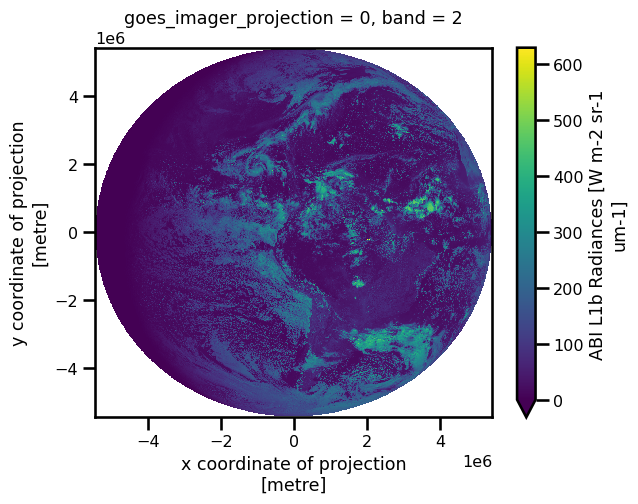

In [10]:
ds.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

### Subsetting

These images are quite large, especially bands 2 and 3.
So we offer the users a way to geoprocess the images with some clipping and rescaling.
This is useful if we also want to look for cross-over satellite images, e.g., GOES & MODIS.

In [11]:
from odc.geo.geom import BoundingBox, Geometry
from odc.geo.geobox import GeoBox

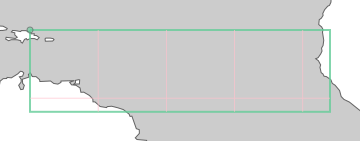

In [12]:
# create a bounding box from xy
lon_bnds = [-70, -15]
lat_bnds = [20, 5]
bbox = BoundingBox.from_xy(x=lon_bnds, y=lat_bnds, crs="4326")

# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

gbox

#### Method I - Bounding Box

The first method is the simplest: a bounding box.
We're normally dealing with images so it's only natural to try for a bounding box approach which outlines an area based on 4 coordinates.

In [13]:
ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=10_000, 
    geometry=gbox,
    method="bounding_box",
)

Loading Radiance file 16/16: OR_ABI-L1b-RadF-M6C16_G16_s20202761400193_e20202761409513_c20202761409582.nc: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.69s/it]


#### Visualize

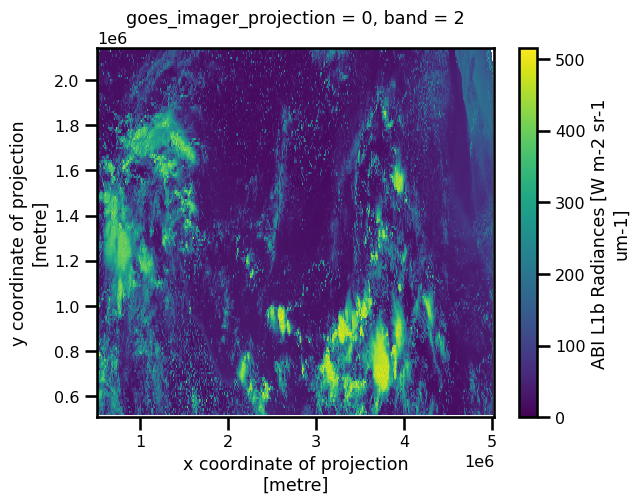

In [14]:
ds.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

#### Method II - Polygon

Sometimes, we have weird geometry so a polygon will allow for more flexible situations.

In [15]:
ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=10_000, 
    geometry=gbox,
    method="polygon",
)

Loading Radiance file 16/16: OR_ABI-L1b-RadF-M6C16_G16_s20202761410193_e20202761419513_c20202761419578.nc: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.10s/it]


#### Visualize

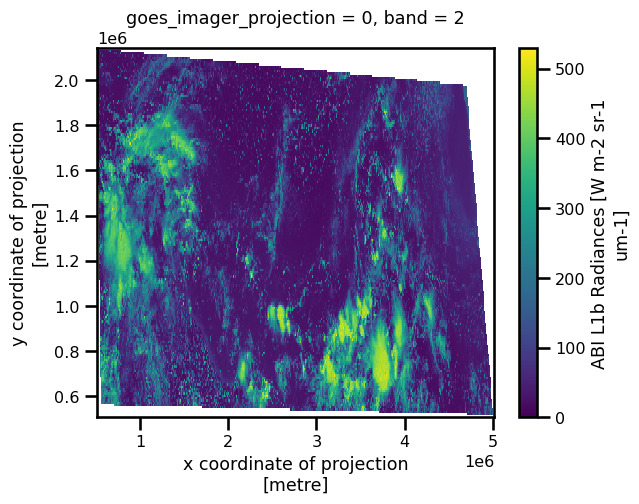

In [16]:
ds.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

In [17]:
from odc.geo.data import ocean_geom, country_geom

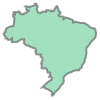

In [18]:
brazil_country_geom = country_geom(iso3="BRA")
brazil_country_geom

In [19]:
type(brazil_country_geom)

odc.geo.geom.Geometry

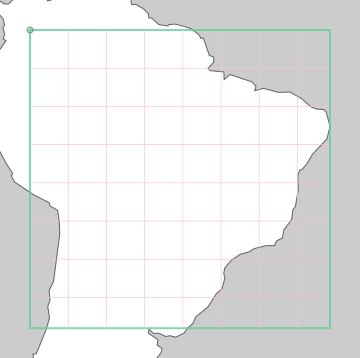

In [20]:
# create a geobox
gbox = GeoBox.from_geopolygon(brazil_country_geom, resolution=0.01, crs=brazil_country_geom.crs)
gbox

In [21]:
ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=10_000, 
    geometry=gbox,
    method="polygon",
)

Loading Radiance file 16/16: OR_ABI-L1b-RadF-M6C16_G16_s20202761410193_e20202761419513_c20202761419578.nc: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.09s/it]


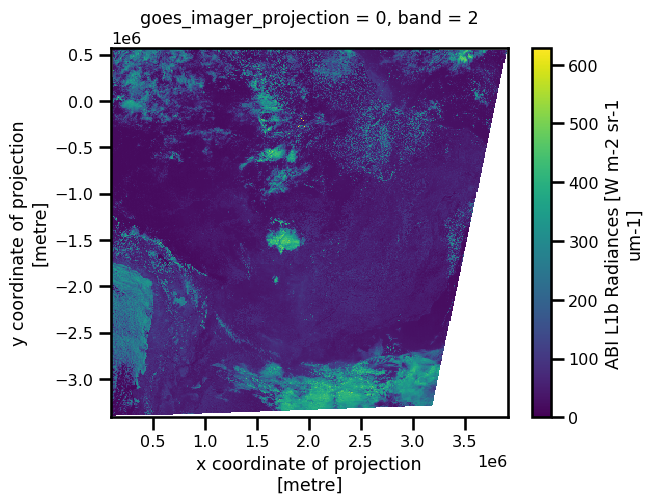

In [22]:
ds.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

### Example: MODIS

In [23]:
# list of all .hdf files in the directory
modis_read_dir = Path("/pool/usuarios/juanjohn/data/iti/pipeline_test/modis/clean")
all_modis_files = get_list_filenames(modis_read_dir, ".nc")

len(all_modis_files)

12

In [30]:
from rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor import regrid_to_regular
# load MODIS
ds_modis = xr.open_dataset(all_modis_files[0])

# regrid to regular grid
# preserve coordinates
band_wavelength = ds_modis.band_wavelength
time = ds_modis.time
ds_modis = regrid_to_regular(ds_modis["radiance"], resolution=0.05)
ds_modis["band_wavelength"] = band_wavelength
ds_modis["time"] = time
ds_modis

<xarray.Dataset> Size: 790MB
Dimensions:          (band: 38, latitude: 2092, longitude: 2485,
                      band_wavelength: 38, time: 1)
Coordinates: (6)
Data variables: (1)

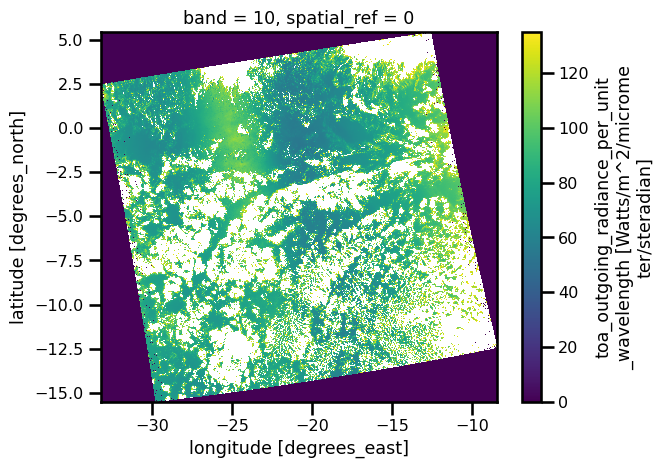

In [44]:
ds_modis.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

In [42]:
ds_modis.rio.resolution()

(0.01, -0.01)

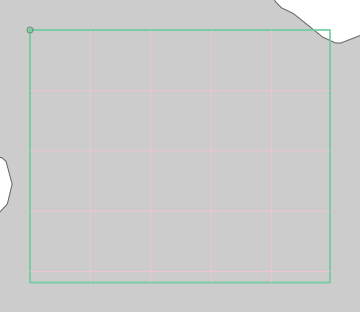

In [43]:
# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(ds_modis.rio.bounds(), shape=ds_modis.rio.shape, crs=ds_modis.rio.crs)

gbox

In [49]:
ds = geoprocess_goes16_file(
    set_goes_files,
    resolution=5_000, 
    geometry=gbox,
    method="bounding_box",
)

Loading Radiance file 16/16: OR_ABI-L1b-RadF-M6C16_G16_s20202761410193_e20202761419513_c20202761419578.nc: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:36<00:00,  2.27s/it]


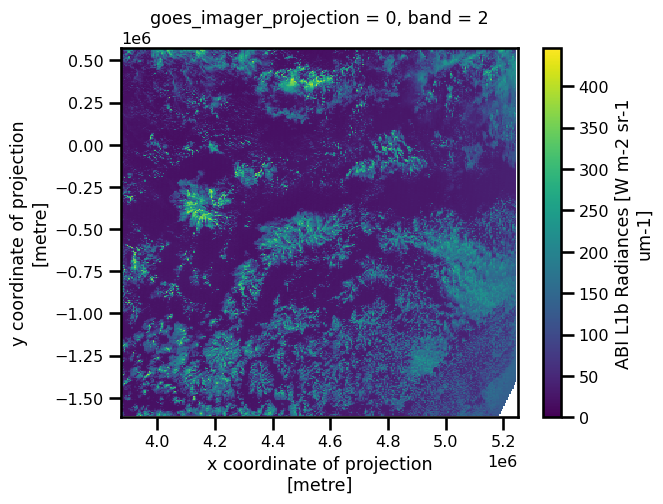

In [50]:
ds.radiance.isel(band=1).plot(cmap="viridis", vmin=0.0)

In [11]:
%%time

dst_crs = CRS("EPSG:4326")
dst_resolution = 0.25
ds_goes_reproject = ds_goes.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)

CPU times: user 536 ms, sys: 203 ms, total: 739 ms
Wall time: 742 ms


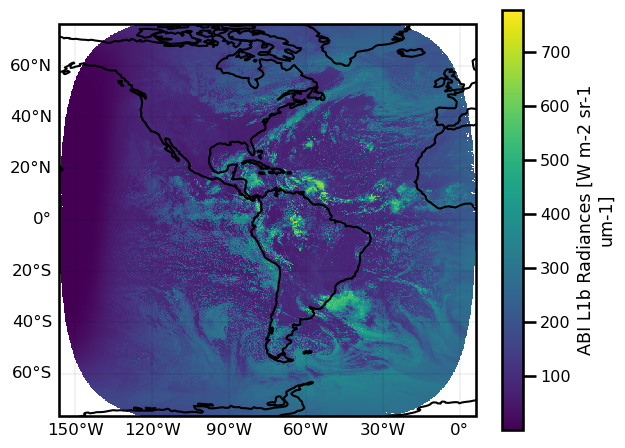

In [13]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ds_goes_reproject.Rad.isel(band=0).plot(
    ax=ax,
    x="x", y="y", 
    transform=ccrs.PlateCarree(),
)

ax.set(
    title=""
)
ax.coastlines()

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

### Reprojection + Clipping

It doesn't make so much sense to do reprojection because it can be **very** expensive.
However, what might be useful is to take an existing MODIS image and try to subset the band based on the image.

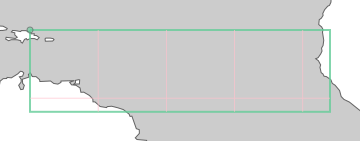

In [37]:
# create a bounding box from xy
# create a bounding box from xy
lon_bnds = [-70, -15]
lat_bnds = [20, 5]
bbox = BoundingBox.from_xy(x=lon_bnds, y=lat_bnds, crs="4326")

# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

gbox